In [31]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline
import time

In [32]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, 
                 error_bad_lines=False)
print(df.shape)
df.head()

(303, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [9]:
# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)
y

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,

To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

In [11]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

In [33]:
# Calculate predicted values.
start = time.time()
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)
print("Kmeans",time.time() - start)

0.05984091758728027


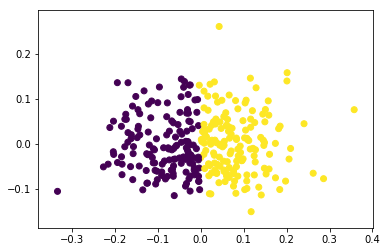

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99


In [34]:
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

In [35]:
#Now let's try MiniBatch:

In [36]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
start = time.time()
predict_mini = minibatchkmeans.predict(X_pca)
print(time.time() - start)
# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

0.001001596450805664
Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0      149   20
1        0  134


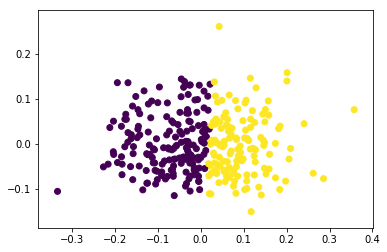

In [37]:
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict_mini)
plt.show()

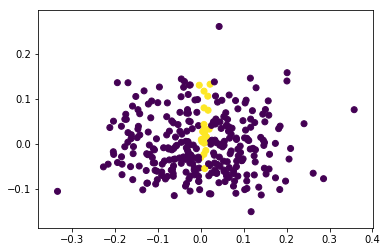

In [38]:
dfs = pd.DataFrame({'ypred':y_pred, 'mini':predict_mini, 'true':y})
dfs['difference'] = np.where(dfs.ypred == dfs.mini, 0,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dfs.difference)
plt.show()

## Drill: More clusters?

Your task is to take the $k$-means code here and see what happens when you change the value of $k$.  What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor.  Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

In [39]:
df.corr()[13]

0     0.222853
1     0.224469
2     0.407075
3     0.157754
4     0.070909
5     0.059186
6     0.183696
7    -0.415040
8     0.397057
9     0.504092
10    0.377957
13    1.000000
Name: 13, dtype: float64

In [59]:
x = normalize(df[[2,7,8,9,10]])
n = 2
# Calculate predicted values.
start = time.time()
y_pred = KMeans(n_clusters=n).fit_predict(x)
print("Kmeans",time.time() - start)

start = time.time()
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=n,
    batch_size=200)
minibatchkmeans.fit(x)
predict_mini = minibatchkmeans.predict(x)
print("mb",time.time() - start)
dfs = pd.DataFrame({'ypred':y_pred, 'mini':predict_mini, 'true':y})
dfs['kmacc'] = np.where(dfs.ypred == dfs.true,1,0)
dfs['mbacc'] = np.where(dfs.mini == dfs.true,1,0)
print('kmeans',dfs['kmacc'].sum(), "out of", len(dfs))
print('minibatch',dfs['mbacc'].sum(), "out of", len(dfs))

Kmeans 0.0578460693359375
mb 0.08085107803344727
kmeans 232 out of 303
minibatch 231 out of 303


In [69]:
# Reduce it to two components.
X_pca = PCA(2).fit_transform(x)
n = 2
# Calculate predicted values.
start = time.time()
y_pred = KMeans(n_clusters=n).fit_predict(X_pca)
print("Kmeans",time.time() - start)

start = time.time()
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=n,
    batch_size=200)
minibatchkmeans.fit(X_pca)
predict_mini = minibatchkmeans.predict(X_pca)
print("mb",time.time() - start)
dfs = pd.DataFrame({'ypred':y_pred, 'mini':predict_mini, 'true':y})
dfs['kmacc'] = np.where(dfs.ypred == dfs.true,1,0)
dfs['mbacc'] = np.where(dfs.mini == dfs.true,1,0)

Kmeans 0.03690147399902344
mb 0.03989148139953613
kmeans 70 out of 303
minibatch 71 out of 303


In [74]:
# Reduce it to two components.
X_pca = PCA(2).fit_transform(x)
n = 3
# Calculate predicted values.
start = time.time()
y_pred = KMeans(n_clusters=n).fit_predict(X_pca)
print("Kmeans",time.time() - start)

start = time.time()
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=n,
    batch_size=200)
minibatchkmeans.fit(X_pca)
predict_mini = minibatchkmeans.predict(X_pca)
print("mb",time.time() - start)
dfs = pd.DataFrame({'ypred':y_pred, 'mini':predict_mini, 'true':y})
dfs['kmacc'] = np.where(dfs.ypred == dfs.true,1,0)
dfs['mbacc'] = np.where(dfs.mini == dfs.true,1,0)
display(pd.crosstab(dfs.true, dfs.ypred))
pd.crosstab(dfs.true, dfs.mini)

Kmeans 0.0857689380645752
mb 0.038895606994628906


ypred,0,1,2
true,,,
0,59,20,60
1,9,102,53


mini,0,1,2
true,,,
0,44,16,79
1,92,61,11
